In [1]:
import os
os.chdir('/home/rozmar/Scripts/Python/DataPipeline')
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import datajoint as dj
dj.conn()
from pipeline import pipeline_tools
from pipeline import lab, experiment, ephys_patch, ephysanal, imaging, imaging_gt
from voltageimaging import voltage_imaging_utils
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import time
from plot.plot_imaging import *
import scipy
import scipy.ndimage as ndimage
font = {'size'   : 16}

matplotlib.rc('font', **font)
from pathlib import Path

homefolder = dj.config['locations.mr_share']

def moving_average(a, n=3) : # moving average 
    if n>2:
        begn = int(np.ceil(n/2))
        endn = int(n-begn)-1
        a = np.concatenate([a[begn::-1],a,a[:-endn:-1]])
    ret = np.cumsum(a,axis = 0, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


Connecting rozmar@mesoscale-activity.datajoint.io:3306


In [2]:
# set parameters - enter the subject ID and movie number

tau_1_on_voltron = .64/1000
tau_2_on_voltron = 4.1/1000
tau_1_ratio_on_voltron =  .61
tau_1_off_voltron = .78/1000  # not used
tau_2_off_voltron = 3.9/1000  # not used
tau_1_ratio_off_voltron = 55  # not used
    
downsampled_rate = 10000 #Hz - the original is 200kHz
junction_potential = 13.5


key ={'subject_id':456462}
key['movie_number'] = 3 #3

#key ={'subject_id':462149}
#key['movie_number'] = 0 #3

key = (imaging_gt.CellMovieCorrespondance()&key).fetch(as_dict = True)[0]
key['roi_type'] = "VolPy"
sweep_numbers = key['sweep_numbers']
del key['sweep_numbers']

In [3]:
# getting the ophys traces
session_time, cell_recording_start = (experiment.Session()*ephys_patch.Cell()&key).fetch1('session_time','cell_recording_start')
first_movie_start_time =  np.min(np.asarray(((imaging.Movie()*imaging_gt.GroundTruthROI())&key).fetch('movie_start_time'),float))
first_movie_start_time_real = first_movie_start_time + session_time.total_seconds()
frame_times = (imaging.MovieFrameTimes()&key).fetch1('frame_times') - cell_recording_start.total_seconds() + session_time.total_seconds()
roi_dff,roi_f0,roi_spike_indices,framerate = (imaging.Movie()*imaging.ROI*imaging_gt.GroundTruthROI()&key).fetch1('roi_dff','roi_f0','roi_spike_indices','movie_frame_rate')
roi_spike_indices = roi_spike_indices-1
roi_f = (roi_dff*roi_f0)+roi_f0


# calculating F0s

# single exponential fit on F
xvals = frame_times-frame_times[0]
yvals = roi_f
out = scipy.optimize.curve_fit(lambda t,a,b,c,d,e: a*np.exp(-t/b)*0 + c + d*np.exp(-t/e),  xvals,  yvals,bounds=((0,0,-np.inf,0,0),(np.inf,np.inf,np.inf,np.inf,np.inf)))
f0_fit_f = out[0][0]*np.exp(-xvals/out[0][1])+out[0][2] +out[0][3]*np.exp(-xvals/out[0][4])
dff_fit = (roi_f-f0_fit_f)/f0_fit_f


aptimes = (ephysanal.ActionPotential()*imaging_gt.ROIAPWave()*imaging_gt.GroundTruthROI()&key).fetch('ap_max_time')
aptimes = np.array(aptimes ,float)
real_spike_indices = list()
for aptime in aptimes:
    real_spike_indices.append(np.argmax(frame_times>aptime))
real_spike_indices = np.asarray(real_spike_indices)

# single exponential fit on AP peak values
xvals = frame_times[real_spike_indices]-frame_times[real_spike_indices][0]
yvals = roi_f[real_spike_indices]
out = scipy.optimize.curve_fit(lambda t,a,b,c,d,e: a*np.exp(-t/b)*0 + c + d*np.exp(-t/e),  xvals,  yvals,bounds=((0,0,-np.inf,0,0),(np.inf,np.inf,np.inf,np.inf,np.inf)))
xvals = frame_times-frame_times[real_spike_indices][0]
f0_fit_ap_peak = out[0][0]*np.exp(-xvals/out[0][1])+out[0][2] +out[0][3]*np.exp(-xvals/out[0][4])
dff_fit_ap_peak = (roi_f-f0_fit_ap_peak)/f0_fit_ap_peak

# single exponential fit on values before AP peak
xvals = frame_times[real_spike_indices-1]-frame_times[real_spike_indices-1][0]
yvals = roi_f[real_spike_indices-1]
out = scipy.optimize.curve_fit(lambda t,a,b,c,d,e: a*np.exp(-t/b)*0 + c + d*np.exp(-t/e),  xvals,  yvals,bounds=((0,0,-np.inf,0,0),(np.inf,np.inf,np.inf,np.inf,np.inf)))
xvals = frame_times-frame_times[real_spike_indices-1][0]
f0_fit_ap_thresh = out[0][0]*np.exp(-xvals/out[0][1])+out[0][2] +out[0][3]*np.exp(-xvals/out[0][4])
dff_fit_ap_thresh = (roi_f-f0_fit_ap_thresh)/f0_fit_ap_thresh

In [4]:
# extracting ephys and convolving with voltron kinetics
traces=list()
traces_t=list()
traces_conv = list()
for sweep_number in sweep_numbers:
    #%
    key_sweep = key.copy()
    key_sweep['sweep_number'] = sweep_number

    neutralizationenable,e_sr= (ephys_patch.SweepMetadata()&key_sweep).fetch1('neutralizationenable','sample_rate')
    try:
        uncompensatedRS =  float((ephysanal.SweepSeriesResistance()&key_sweep).fetch1('series_resistance_residual'))
    except:
        uncompensatedRS = 0
    v = (ephys_patch.SweepResponse()&key_sweep).fetch1('response_trace')
    i = (ephys_patch.SweepStimulus()&key_sweep).fetch1('stimulus_trace')
    tau_1_on =.1/1000
    t = np.arange(0,.001,1/e_sr)
    f_on = np.exp(t/tau_1_on) 
    f_on = f_on/np.max(f_on)
    kernel = np.concatenate([f_on,np.zeros(len(t))])[::-1]
    kernel  = kernel /sum(kernel )  
    i_conv = np.convolve(i,kernel,'same')
    v_comp = (v - i*uncompensatedRS*10**6)*1000 - junction_potential
    i = i * 10**12
    
    sweep_start_time  = float((ephys_patch.Sweep()&key_sweep).fetch('sweep_start_time')) 
    trace_t = np.arange(len(v))/e_sr + sweep_start_time
    downsample_factor = int(np.round(e_sr/downsampled_rate))
    #%downsampling
    v_out = moving_average(v_comp, n=downsample_factor)
    v_out = v_out[int(downsample_factor/2)::downsample_factor]
    i_out = moving_average(i, n=downsample_factor)
    i_out = i_out[int(downsample_factor/2)::downsample_factor]
    t_out = moving_average(trace_t, n=downsample_factor)
    t_out = t_out[int(downsample_factor/2)::downsample_factor]
    
    #convolving
    t = np.arange(0,.01,1/downsampled_rate)
    f_on = tau_1_ratio_on_voltron*np.exp(t/tau_1_on_voltron) + (1-tau_1_ratio_on_voltron)*np.exp(-t/tau_2_on_voltron)
    f_off = tau_1_ratio_off_voltron*np.exp(t[::-1]/tau_1_off_voltron) + (1-tau_1_ratio_off_voltron)*np.exp(-t[::-1]/tau_2_off_voltron)
    f_on = f_on/np.max(f_on)
    f_off = f_off/np.max(f_off)
    kernel = np.concatenate([f_on,np.zeros(len(f_off))])[::-1]
    kernel  = kernel /sum(kernel )
    
    trace_conv0 = np.convolve(np.concatenate([v_out[500::-1],v_out,v_out[:-500:-1]]),kernel,mode = 'same') 
    trace_conv0 = trace_conv0[500:500+len(v_out)]
    
    kernel = np.ones(int(np.round(downsampled_rate/framerate)))
    kernel  = kernel /sum(kernel )
    trace_conv = np.convolve(np.concatenate([v_out[500::-1],trace_conv0,v_out[:-500:-1]]),kernel,mode = 'same') 
    trace_conv = trace_conv[500:500+len(v_out)]
# =============================================================================
#     trace_conv = trace_conv0
# =============================================================================
    
    
    
    traces.append(v_out)
    traces_t.append(t_out)
    traces_conv.append(trace_conv)

In [5]:
#%% generate downsampled ephys trace - each frame gets a
traces_t_all = np.concatenate(traces_t)
traces_conv_all = np.concatenate(traces_conv)
trace_im = list()
e_o_timediff =list()
for frame_time in frame_times:
    idx = np.argmax(traces_t_all>frame_time)
    e_o_timediff.append(frame_time-traces_t_all[idx])
    trace_im.append(traces_conv_all[idx])  
thrashidx = np.abs(e_o_timediff) > 2*np.median(np.diff(traces_t_all))
trace_im=np.asarray(trace_im)
trace_im[thrashidx]=np.nan

/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/rozmar/anaconda3/envs/datajoint/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


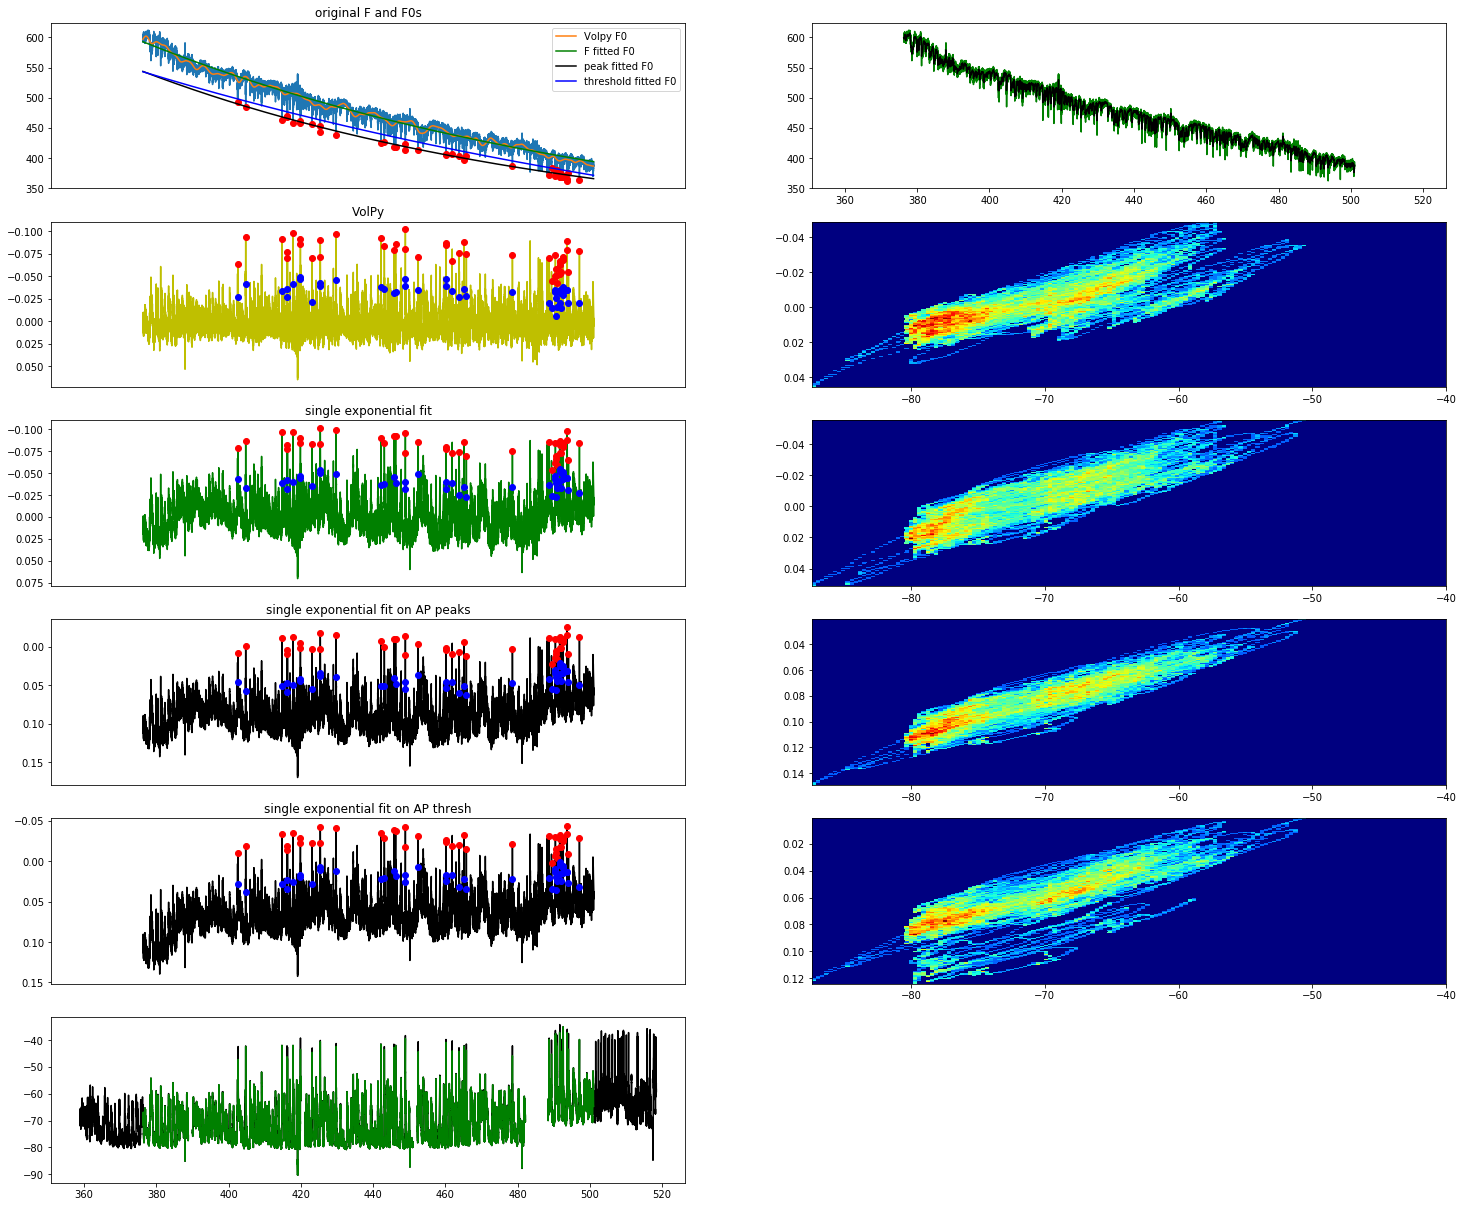

In [6]:
#%% plot
sigma = .025
roi_f_filt = ndimage.gaussian_filter(roi_f,sigma*framerate)
roi_dff_filt = ndimage.gaussian_filter(roi_dff,sigma*framerate)
dff_fit_filt = ndimage.gaussian_filter(dff_fit,sigma*framerate)
dff_fit_ap_peak_filt =ndimage.gaussian_filter(dff_fit_ap_peak,sigma*framerate)
dff_fit_ap_thresh_filt =ndimage.gaussian_filter(dff_fit_ap_thresh,sigma*framerate)
trace_im_filt = ndimage.gaussian_filter(trace_im,sigma*framerate)


fig=plt.figure(figsize = [25,25])
ax = fig.add_subplot(721)
ax.plot(frame_times,roi_f)
ax.plot(frame_times[real_spike_indices],roi_f[real_spike_indices],'ro')
#ax.plot(frame_times[real_spike_indices[spikes_needed]],roi_f[real_spike_indices[spikes_needed]],'bo')
ax.plot(frame_times,roi_f0,label = 'Volpy F0')
ax.plot(frame_times,f0_fit_f,'g-',label = 'F fitted F0')
ax.plot(frame_times,f0_fit_ap_peak,'k-',label = 'peak fitted F0')
ax.plot(frame_times,f0_fit_ap_thresh,'b-',label = 'threshold fitted F0')
ax.legend()
ax.axes.get_xaxis().set_visible(False)
ax.set_title('original F and F0s')

ax_dff = fig.add_subplot(723, sharex=ax)
ax_dff.plot(frame_times,roi_dff,'y-') #moving_average(roi_dff,4)
#ax_dff.plot(frame_times,roi_dff_filt,'r-')
ax_dff.plot(frame_times[real_spike_indices],roi_dff[real_spike_indices],'ro')
ax_dff.plot(frame_times[real_spike_indices],roi_dff_filt[real_spike_indices],'bo')
ax_dff.axes.get_xaxis().set_visible(False)
ax_dff.set_title('VolPy')
ax_dff.invert_yaxis()

ax_dff_f0fit = fig.add_subplot(725, sharex=ax)
ax_dff_f0fit.plot(frame_times,dff_fit,'g-')
#ax_dff_f0fit.plot(frame_times,dff_fit_filt,'r-')
ax_dff_f0fit.plot(frame_times[real_spike_indices],dff_fit[real_spike_indices],'ro')
ax_dff_f0fit.plot(frame_times[real_spike_indices],dff_fit_filt[real_spike_indices],'bo')
ax_dff_f0fit.set_title('single exponential fit')
ax_dff_f0fit.axes.get_xaxis().set_visible(False)
ax_dff_f0fit.invert_yaxis()

ax_dff_peakfit = fig.add_subplot(727, sharex=ax)
ax_dff_peakfit.plot(frame_times,dff_fit_ap_peak,'k-')
#ax_dff_peakfit.plot(frame_times,dff_fit_ap_peak_filt,'r-')
ax_dff_peakfit.plot(frame_times[real_spike_indices],dff_fit_ap_peak[real_spike_indices],'ro')
ax_dff_peakfit.plot(frame_times[real_spike_indices],dff_fit_ap_peak_filt[real_spike_indices],'bo')
ax_dff_peakfit.set_title('single exponential fit on AP peaks')
ax_dff_peakfit.axes.get_xaxis().set_visible(False)
ax_dff_peakfit.invert_yaxis()

ax_dff_threshfit = fig.add_subplot(729, sharex=ax)
ax_dff_threshfit.plot(frame_times,dff_fit_ap_thresh,'k-')
#ax_dff_threshfit.plot(frame_times,dff_fit_ap_thresh_filt,'r-')
ax_dff_threshfit.plot(frame_times[real_spike_indices],dff_fit_ap_thresh[real_spike_indices],'ro')
ax_dff_threshfit.plot(frame_times[real_spike_indices],dff_fit_ap_thresh_filt[real_spike_indices],'bo')
ax_dff_threshfit.set_title('single exponential fit on AP thresh')
ax_dff_threshfit.axes.get_xaxis().set_visible(False)
ax_dff_threshfit.invert_yaxis()


ax_ephys = fig.add_subplot(7,2,11, sharex=ax)
for t,v,v_conv in zip(traces_t,traces,traces_conv):
    #ax_ephys.plot(t,v,'k-')
    ax_ephys.plot(t,v_conv,'k-')
ax_ephys.plot(frame_times,trace_im,'g-')
#ax_ephys.plot(frame_times,trace_im_filt,'r-')


ax_filt = fig.add_subplot(722, sharex=ax)
ax_filt.plot(frame_times,roi_f,'g-')
ax_filt.plot(frame_times,roi_f_filt,'k-')


ax_dff_corr = fig.add_subplot(724)
ax_dff_corr.hist2d(trace_im_filt,roi_dff_filt,150,[[np.nanmin(trace_im_filt),-40],[np.nanmin(roi_dff_filt),np.nanmax(roi_dff_filt)]],norm=colors.PowerNorm(gamma=0.3),cmap =  plt.get_cmap('jet'))
ax_dff_corr.invert_yaxis()

ax_dff_f0fit_corr = fig.add_subplot(726)
ax_dff_f0fit_corr.hist2d(trace_im_filt,dff_fit_filt,150,[[np.nanmin(trace_im_filt),-40],[np.nanmin(dff_fit_filt),np.nanmax(dff_fit_filt)]],norm=colors.PowerNorm(gamma=0.3),cmap =  plt.get_cmap('jet'))
ax_dff_f0fit_corr.invert_yaxis()

ax_dff_peakfit_corr = fig.add_subplot(728)
ax_dff_peakfit_corr.hist2d(trace_im_filt,dff_fit_ap_peak_filt,150,[[np.nanmin(trace_im_filt),-40],[np.nanmin(dff_fit_ap_peak_filt),np.nanmax(dff_fit_ap_peak_filt)]],norm=colors.PowerNorm(gamma=0.3),cmap =  plt.get_cmap('jet'))
ax_dff_peakfit_corr.invert_yaxis()

ax_dff_threshfit_corr = fig.add_subplot(7,2,10)
ax_dff_threshfit_corr.hist2d(trace_im_filt,dff_fit_ap_thresh_filt,150,[[np.nanmin(trace_im_filt),-40],[np.nanmin(dff_fit_ap_thresh_filt),np.nanmax(dff_fit_ap_thresh_filt)]],norm=colors.PowerNorm(gamma=0.3),cmap =  plt.get_cmap('jet'))
ax_dff_threshfit_corr.invert_yaxis()